In [1]:
import os
import os.path as pth
import json
import shutil
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
BASE_MODEL_NAME = 'MobileNetV2-for-upload'
my_model_base = keras.applications.mobilenet_v2
my_model = my_model_base.MobileNetV2

config = {
    'is_zscore':True,
    
    # 'input_shape': (540, 960, 3),
    'aug': {
        'resize': (270, 480),  # just resize
        #'resize': (405, 720),  # resize 75% and random crop.
    },
    #'input_shape': (224, 360, 3),
    'input_shape': (270, 480, 3),

    'output_activation': 'softmax',
    'num_class': 1049,
    'output_size': 1049,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'batch_size': 64,
    'buffer_size': 256,
    'loss': 'CategoricalCrossentropy',
    
    'num_epoch': 10000,
    'learning_rate': 1e-3,
    
    'random_state': 7777
}

In [4]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def resize_and_crop_func(image, label):
    result_image = tf.image.resize(image, config['aug']['resize'])
    result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)  # crop revived.
    return result_image, label

def image_aug_func(image, label):
    pass
    return image, label

def post_process_func(image, label):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    onehot_label = tf.one_hot(label, depth=config['num_class'])
    return result_image, onehot_label

In [5]:
data_base_path = pth.join('data', 'public') 
os.makedirs(data_base_path, exist_ok=True)

In [6]:
category_csv_name = 'category.csv'
category_json_name = 'category.json'
submission_csv_name = 'sample_submisstion.csv'
train_csv_name = 'train.csv'

# train_zip_name = 'train.zip'
train_tfrecord_name = 'all_train.tfrecords'
train_tfrecord_path = pth.join(data_base_path, train_tfrecord_name)
val_tfrecord_name = 'all_val.tfrecords'
val_tfrecord_path = pth.join(data_base_path, val_tfrecord_name)
# test_zip_name = 'test.zip'
test_tfrecord_name = 'test.tfrecords'
test_tfrecord_path = pth.join(data_base_path, test_tfrecord_name)

In [7]:
train_csv_path = pth.join(data_base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
train_dict = {k:v for k, v in train_df.values}

submission_csv_path = pth.join(data_base_path, submission_csv_name)
submission_df = pd.read_csv(submission_csv_path)
# submission_df.head()

category_csv_path = pth.join(data_base_path, category_csv_name)
category_df = pd.read_csv(category_csv_path)
category_dict = {k:v for k, v in category_df.values}
# category_df.head()

In [8]:
train_tfrecord_path

'data/public/all_train.tfrecords'

### Model

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
from tqdm import tqdm

import itertools
from itertools import product, combinations

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm

In [10]:
conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

In [11]:
def build_cnn(config):
    input_layer = Input(shape=config['input_shape'], name='input_layer')
    pret_model = my_model(
        input_tensor=input_layer, include_top=False, weights='imagenet', 
        input_shape=config['input_shape'], pooling=config['between_type'], 
        classes=config['output_size']
    )

    pret_model.trainable = False
    
    x = pret_model.output
    
    if config['between_type'] == None:
        x = Flatten(name='flatten_layer')(x)
        
    if config['is_dropout']:
        x = Dropout(config['dropout_rate'], name='output_dropout')(x)    
            
    x = Dense(config['output_size'], activation=config['output_activation'], 
          name='output_fc')(x)
#     x = Activation(activation=config['output_activation'], name='output_activation')(x)
    model = Model(inputs=input_layer, outputs=x, name='{}'.format(BASE_MODEL_NAME))

    return model

In [12]:
model = build_cnn(config)
model.summary(line_length=150)
del model

Model: "MobileNetV2-for-upload"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_layer (InputLayer)                         [(None, 224, 360, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)                        (None, 225, 361, 3)              0                 input_layer[0][0]                                 
______________________________________________________________________________________________________________________________________________________
Conv1 (Conv2D)                                   (None, 112, 1

In [13]:
origin_train_len = len(train_df) / 5 * 4
origin_val_len = len(train_df) / 5 * 1

train_num_steps = int(np.ceil((origin_train_len)/config['batch_size']))
val_num_steps = int(np.ceil((origin_val_len)/config['batch_size']))

In [14]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

MobileNetV2-for-upload_resize_405_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
Epoch 1/16
882/882 [==============================] - 549s 623ms/step - loss: 3.5756 - acc: 0.4032 - precision: 0.9266 - recall: 0.1955 - auc: 0.8559 - val_loss: 2.3028 - val_acc: 0.5697 - val_precision: 0.9009 - val_recall: 0.4030 - val_auc: 0.9275
Epoch 2/16
882/882 [==============================] - 507s 575ms/step - loss: 1.7081 - acc: 0.6660 - precision: 0.9078 - recall: 0.5329 - auc: 0.9509 - val_loss: 1.9530 - val_acc: 0.6275 - val_precision: 0.8698 - val_recall: 0.5251 - val_auc: 0.9358
Epoch 3/16
882/882 [==============================] - 507s 575ms/step - loss: 1.3232 - acc: 0.7320 - precision: 0.8974 - recall: 0.6482 - auc: 0.9619 - val_loss: 1.8555 - val_acc: 0.6518 - val_precision: 0.8495 - val_recall: 0.5703 - val_auc: 0.9374
Epoch 4/16
882/882 [==============================] - 504s 572ms/step - loss: 1.1304 - acc: 0.7685 - precision: 0.8921 - recall: 0.7044 - auc: 0

Epoch 2/10000
881/882 [============================>.] - ETA: 0s - loss: 0.7151 - acc: 0.8269 - precision: 0.9129 - recall: 0.7831 - auc: 0.9838
Epoch 00002: val_loss improved from 14.08834 to 5.68478, saving model to data/public/checkpoint/MobileNetV2-for-upload_resize_405_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000002-5.684779-0.715142.hdf5
882/882 [==============================] - 519s 588ms/step - loss: 0.7151 - acc: 0.8268 - precision: 0.9129 - recall: 0.7830 - auc: 0.9838 - val_loss: 5.6848 - val_acc: 0.4538 - val_precision: 0.4888 - val_recall: 0.4434 - val_auc: 0.8105
Epoch 3/10000
881/882 [============================>.] - ETA: 0s - loss: 0.5157 - acc: 0.8710 - precision: 0.9330 - recall: 0.8378 - auc: 0.9893
Epoch 00003: val_loss improved from 5.68478 to 4.33813, saving model to data/public/checkpoint/MobileNetV2-for-upload_resize_405_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000003-4.338133-0.515898.hdf5
882/882 

Epoch 17/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9797 - precision: 0.9848 - recall: 0.9751 - auc: 0.9993
Epoch 00017: val_loss did not improve from 1.61835
882/882 [==============================] - 605s 686ms/step - loss: 0.0704 - acc: 0.9797 - precision: 0.9848 - recall: 0.9751 - auc: 0.9993 - val_loss: 1.7293 - val_acc: 0.7628 - val_precision: 0.7971 - val_recall: 0.7529 - val_auc: 0.9385
Epoch 18/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9826 - precision: 0.9868 - recall: 0.9788 - auc: 0.9995
Epoch 00018: val_loss did not improve from 1.61835
882/882 [==============================] - 604s 685ms/step - loss: 0.0604 - acc: 0.9826 - precision: 0.9867 - recall: 0.9788 - auc: 0.9995 - val_loss: 1.7696 - val_acc: 0.7557 - val_precision: 0.7918 - val_recall: 0.7451 - val_auc: 0.9368
Epoch 19/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9824 - precision: 0.9866 - recall: 0.9

881/882 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9921 - precision: 0.9935 - recall: 0.9908 - auc: 0.9997
Epoch 00034: val_loss improved from 1.37084 to 1.27451, saving model to data/public/checkpoint/MobileNetV2-for-upload_resize_405_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000034-1.274513-0.027956.hdf5
882/882 [==============================] - 604s 685ms/step - loss: 0.0280 - acc: 0.9921 - precision: 0.9935 - recall: 0.9907 - auc: 0.9997 - val_loss: 1.2745 - val_acc: 0.8119 - val_precision: 0.8451 - val_recall: 0.8027 - val_auc: 0.9533
Epoch 35/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9931 - precision: 0.9941 - recall: 0.9920 - auc: 0.9998
Epoch 00035: val_loss did not improve from 1.27451
882/882 [==============================] - 606s 687ms/step - loss: 0.0244 - acc: 0.9931 - precision: 0.9941 - recall: 0.9920 - auc: 0.9998 - val_loss: 1.2942 - val_acc: 0.8069 - val_precision: 0.8430 - 

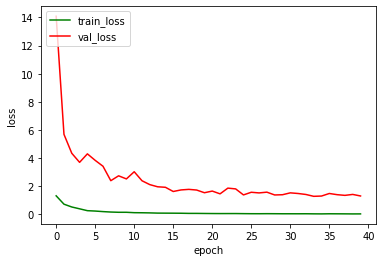

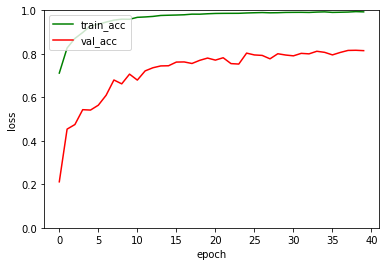

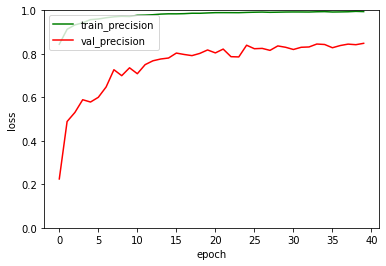

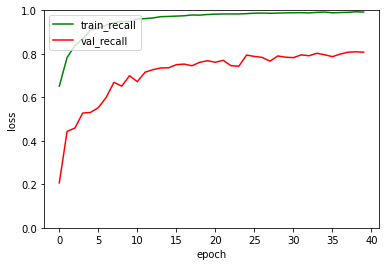

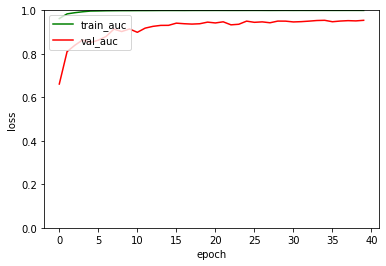

In [15]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.cache()
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(config['buffer_size'])
    dataset = dataset.batch(config['batch_size'])
    dataset = dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.TFRecordDataset(val_tfrecord_path, compression_type='GZIP')
    val_dataset = val_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.shuffle(config['buffer_size'])
    val_dataset = val_dataset.batch(config['batch_size'])
    val_dataset = val_dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.cache()
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
#     model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
#                   metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])

        model_chk_name = sorted(os.listdir(model_path))[-1]
        initial_epoch = int(model_chk_name.split('-')[0])
        model.load_weights(pth.join(model_path, model_chk_name))
    else:
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        model.fit(
            x=dataset, epochs=16, # train only top layers for just a few epochs.
            validation_data=val_dataset, shuffle=True,
            #callbacks = [checkpointer, es], #batch_size=config['batch_size']
            initial_epoch=initial_epoch,
            # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
            verbose=1)
        
        for i, layer in enumerate(model.layers):
            print(i, layer.name)
        
        for layer in model.layers[:135]:
            layer.trainable = False
        for layer in model.layers[135:]:
            layer.trainable = True
        
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
            
    # ### Freeze first layer
    # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
    # conv_list[0].trainable = False
    # # conv_list[1].trainable = False

    os.makedirs(model_path, exist_ok=True)
    model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
    checkpointer = ModelCheckpoint(
        filepath=model_filename, verbose=1, 
        period=1, save_best_only=True, 
        monitor='val_loss'
    )
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=6)

    hist = model.fit(
        x=dataset, epochs=config['num_epoch'], 
        validation_data=val_dataset, shuffle=True,
        callbacks = [checkpointer, es], #batch_size=config['batch_size']
        initial_epoch=initial_epoch,
        # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
        verbose=1
    )

    model_analysis_path = model_path.replace('checkpoint', 'analysis')
    visualization_path = pth.join(model_analysis_path,'visualization')
    os.makedirs(visualization_path, exist_ok=True)
    
    print()
    # clear_output()        
    for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
        fig, ax = plt.subplots()
        ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
        ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        if not each_label == 'loss':
            plt.ylim(0, 1)
        plt.show()
        filename = 'learning_curve_{}'.format(each_label)
#             fig.savefig(pth.join(visualization_path, filename), transparent=True)
        plt.cla()
        plt.clf()
        plt.close('all')

    np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                        loss=hist.history['loss'], 
                        val_loss=hist.history['val_loss'],
                        acc=hist.history['acc'], 
                        val_acc=hist.history['val_acc'],
                        precision=hist.history['precision'], 
                        vaval_precisionl_mae=hist.history['val_precision'],  
                        recall=hist.history['recall'],
                        val_recall=hist.history['val_recall'],
                        auc=hist.history['auc'],
                        val_auc=hist.history['val_auc']
                        )

    model.save(pth.join(model_path, '000000_last.hdf5'))
    K.clear_session()
    del(model)
    
    model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
    with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
        json.dump(config, f)

    chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
    for chk_name in chk_name_list[:-2]:
        os.remove(pth.join(model_path, chk_name))
    # clear_output()

### Inference

In [13]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)  # revive
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [14]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [15]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])

    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)

    submission_df['landmark_id'] = pred_labels
    submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

MobileNetV2-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
      1/Unknown - 0s 141us/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_predict_batch_end` time: 0.2049s). Check your callbacks.
475/475 [==============================] - 258s 543ms/step
